In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda'
num_workers=0
batch_size=10

transform=transforms.Compose([
                            transforms.Grayscale(num_output_channels=1),
                            transforms.Resize((28,28)),
                            transforms.ToTensor()])

train_data=datasets.ImageFolder('../dataset/PlantVillage/train/',transform=transform)
valid_data = datasets.ImageFolder('../dataset/PlantVillage/val/',transform=transform)
test_data = datasets.ImageFolder('../dataset/test/',transform=transform)

train_loader=DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
valid_loader=DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
test_loader=DataLoader(test_data, batch_size=batch_size,num_workers=num_workers)

Train size pts: 16511  validation size pts: 4127


### Visualizing a batch of training data

19 tensor(7) 7
tensor([ 9,  9,  5,  5,  9,  9,  8, 10,  7,  9,  5,  0,  9, 11,  2,  3, 12,  8,
         3,  7])


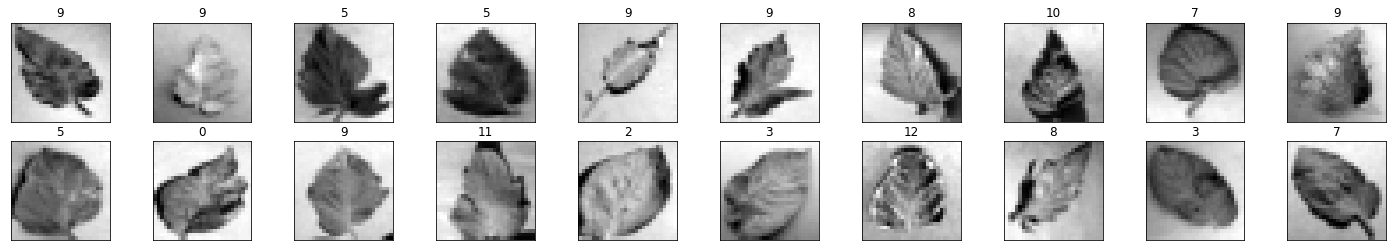

In [3]:
# dataiter= iter

images, labels= next(iter(train_loader))
images= images.numpy()

fig=plt.figure(figsize=(25,4))

for idx in np.arange(batch_size):
    ax=fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    
    ax.set_title(str(labels[idx].item()))

print(idx, labels[idx],labels[idx].item())
print(labels)

### view an image in more detail

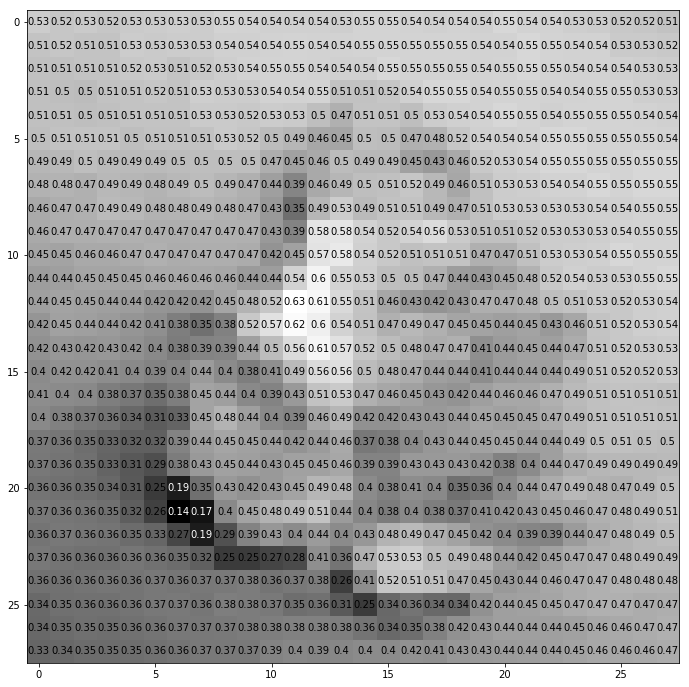

In [4]:
img=np.squeeze(images[1])

fig=plt.figure(figsize=(12,12))

ax=fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height= img.shape
thresh=img.max()/2.5

# print(width, height, thresh)

for x in range(width):
    for y in range(height):
        val= round(img[x][y],2) if img[x][y] !=0 else 0
        
        ax.annotate(str(val), xy=(y,x),
                   horizontalalignment='center',
                   verticalalignment='center',
                   color='white' if img[x][y]<thresh else 'black')

### Architecture

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        hidden_3 = 512
        hidden_4 = 512
        
        self.fc1 = nn.Linear(28 * 28, hidden_1)# linear layer (784 -> hidden_1)
        
        self.fc2 = nn.Linear(hidden_1, hidden_2)# linear layer (n_hidden -> hidden_2)
        
        self.fc3 = nn.Linear(hidden_2,hidden_3) # linear layer (hidden_2 -> hidden_3)
        
        self.fc4 = nn.Linear(hidden_3, hidden_4)
        
        self.fc5 = nn.Linear(hidden_4, 15)# linear layer (n_hidden -> 10)
        
        self.dropout = nn.Dropout(0.2)# dropout layer (p=0.2) dropout prevents overfitting of data

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        
        
        x = F.relu(self.fc1(x))# add hidden layer, with relu activation function
        x = self.dropout(x)# add dropout layer
        
        x = F.relu(self.fc2(x))# add hidden layer, with relu activation function
        x = self.dropout(x)# add dropout layer
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = self.fc5(x)# add output layer
        
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=15, bias=True)
  (dropout): Dropout(p=0.2)
)


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [57]:
n_epochs=50
train_loss_list, valid_loss_list = [], []
train_loss_plt=[]
valid_loss_plt = []
valid_accuracy_plt=[]
valid_loss_min=np.Inf
model.cuda()

for epoch in range(n_epochs):
    train_loss=0
    valid_loss=0
    
    model.train()
    for images, labels in train_loader:
        
        images, labels= images.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        output=model(images)
        loss=criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss+=loss.item() * images.size(0)
        
    model.eval()
    for images, labels in valid_loader:
        
        images, labels= images.cuda(), labels.cuda()
        output=model(images)
        
        loss=criterion(output, labels)
        
        valid_loss+= loss.item() * images.size(0)
        
    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss,valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 28.249440 	Validation Loss: 29.537378
Validation loss decreased (inf --> 29.537378).  Saving model ...
Epoch: 2 	Training Loss: 28.016647 	Validation Loss: 29.686374
Epoch: 3 	Training Loss: 27.573813 	Validation Loss: 33.134892
Epoch: 4 	Training Loss: 27.159578 	Validation Loss: 29.316654
Validation loss decreased (29.537378 --> 29.316654).  Saving model ...
Epoch: 5 	Training Loss: 26.868847 	Validation Loss: 27.896504
Validation loss decreased (29.316654 --> 27.896504).  Saving model ...
Epoch: 6 	Training Loss: 26.522728 	Validation Loss: 27.651734
Validation loss decreased (27.896504 --> 27.651734).  Saving model ...
Epoch: 7 	Training Loss: 26.391511 	Validation Loss: 27.505735
Validation loss decreased (27.651734 --> 27.505735).  Saving model ...
Epoch: 8 	Training Loss: 25.932616 	Validation Loss: 26.583628
Validation loss decreased (27.505735 --> 26.583628).  Saving model ...
Epoch: 9 	Training Loss: 25.829483 	Validation Loss: 30.770791
Epoch: 10 	Tr

### SGD with lr=0.1

In [67]:
from copy import deepcopy
train_plot= deepcopy(train_loss_list)
valid_plot= deepcopy(valid_loss_list)

In [68]:
train_plot = np.asarray(train_plot)
valid_plot = np.asarray(valid_plot)

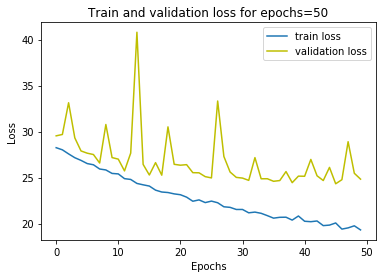

In [76]:
plt.title('Train and validation loss for epochs='+str(n_epochs))
plt.plot(np.arange(len(train_loss_list)),train_loss_list,label='train loss')
plt.plot(np.arange(len(valid_loss_list)),valid_loss_list,color='y',label='validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

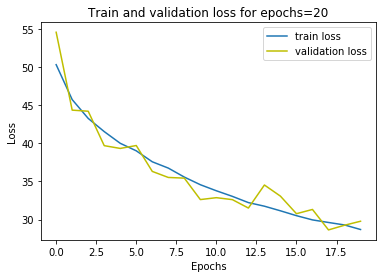

In [56]:
plt.title('Train and validation loss for epochs='+str(n_epochs))
plt.plot(np.arange(len(train_loss_list)),train_loss_list,label='train loss')
plt.plot(np.arange(len(valid_loss_list)),valid_loss_list,color='y',label='validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Adam with lr=0.1

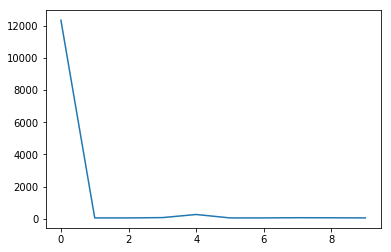

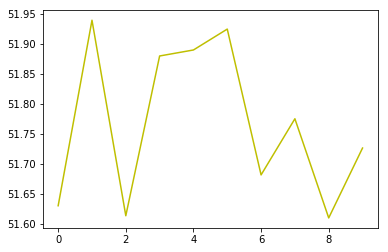

In [17]:
plt.plot(np.arange(len(train_loss_list)),train_loss_list)
plt.show()
plt.plot(np.arange(len(valid_loss_list)),valid_loss_list,color='y')
plt.show()

In [8]:
model.load_state_dict(torch.load('model.pt'))

### Test the trained n/w

In [9]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    data, target= data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.274469

Test Accuracy of     0: 94% (926/980)
Test Accuracy of     1: 96% (1093/1135)
Test Accuracy of     2: 87% (908/1032)
Test Accuracy of     3: 85% (861/1010)
Test Accuracy of     4: 94% (924/982)
Test Accuracy of     5: 90% (805/892)
Test Accuracy of     6: 95% (917/958)
Test Accuracy of     7: 94% (970/1028)
Test Accuracy of     8: 95% (929/974)
Test Accuracy of     9: 94% (949/1009)

Test Accuracy (Overall): 92% (9282/10000)
